# Text classification / Supervised / SVM TD_IDF

In [8]:
import os
import sys

BASE_DIR = ''
SUBJECT_DIR = os.path.join(BASE_DIR, 'data/_subjects') # Collect path to subjects directory

texts = []                                     # list of text samples
labels_index = {}                              # dictionary, label name to numeric id
labels = []                                    # list of label ids
for name in sorted(os.listdir(SUBJECT_DIR)):   # Go through all subdirectories 
    path = os.path.join(SUBJECT_DIR, name)     # Collect each path to subdir
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id          # Collect id to each sub directory/label.
        for fname in sorted(os.listdir(path)):
            if fname.endswith(".txt"):
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    t = t[0:]
                    texts.append(t)            # Append each text from file to text list
                labels.append(label_id)        # Append each label (1-3) to labels list

print(labels_index)

{'_ipynb_checkpoints': 0, 'biology': 1, 'geography': 2, 'physics': 3}


In [9]:
# run nlp_tc.ipynb for LemmaTokenizer
%run utils/nlp_tc.ipynb

In [10]:
import pandas as pd

# Make text list and labels list into pandas DataFrame
data = {}
data['text'] = texts
data['label'] = labels

df = pd.DataFrame(data)

X = df['text']
y = df['label']

In [11]:
# data/subjects(1: 1100, 2: 276, 3: 1126)

show_distribution(y)

1: 350, 2: 276, 3: 295


In [12]:
print(X)

0      What are the major functions of male accessory...
1      EXERCISES\n\n1. Bacteria cannot be seen with t...
2      product. The processes include separation and ...
3      EXERCISES\n\n1. Can you list 10 recombinant pr...
4      SUMMARY\n\nBiotechnology has given to humans s...
                             ...                        
916    reference frame of the moving observer. In thi...
917    the observer counts n crests and the observer\...
918    SUMMARY\n\nMechanical waves can exist in mater...
919    15.5 THE PRINCIPLE 0F SUPERPOSITION OF WAVES\n...
920    are much more difficult to compress than gases...
Name: text, Length: 921, dtype: object


In [13]:
print(y)

0      1
1      1
2      1
3      1
4      1
      ..
916    3
917    3
918    3
919    3
920    3
Name: label, Length: 921, dtype: int64


In [14]:
print('Found %s texts.' % len(texts))

Found 921 texts.


In [181]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

MAX_NUM_WORDS = 4000     # Build a vocabulary which only consider the top features of the corpus

# Create our TC pipline with a base of TfIdf and liblinear SVM with a default to ovr (one-vs-the-rest) scheme.
model = Pipeline([
    # Make text to bag-of-words
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(), max_features=MAX_NUM_WORDS)),
    # Transform word count to frequency
    ('tfidf', TfidfTransformer(sublinear_tf=True)),     
    ('clf',LinearSVC(random_state=42, tol=1e-3, max_iter=50))
])

In [182]:
from sklearn.model_selection import train_test_split

VALIDATION_SPLIT = 0.21

# Split dataset into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)

# Fit training set from X (text) and y (labels)
model.fit(X_train, y_train)

# Collect predictions
y_pred = model.predict(X_test)

In [183]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [184]:
# Save accurate score from evaluation between prediction and test set
acc_model = accuracy_score(y_test, y_pred)
# Save classification report with precision, recall, f1-score
class_report = classification_report(y_test, y_pred)
# Save confusion matrix for model result
confusion_matrix = confusion_matrix(y_test, y_pred)

In [147]:
#print(model.get_params()) 

In [173]:
%run utils/heatmap_tc.ipynb

In [185]:
print(acc_model)

0.9896907216494846


In [186]:
print(class_report)

              precision    recall  f1-score   support

           1       0.99      0.99      0.99        78
           2       0.98      1.00      0.99        56
           3       1.00      0.98      0.99        60

    accuracy                           0.99       194
   macro avg       0.99      0.99      0.99       194
weighted avg       0.99      0.99      0.99       194



<Figure size 432x288 with 0 Axes>

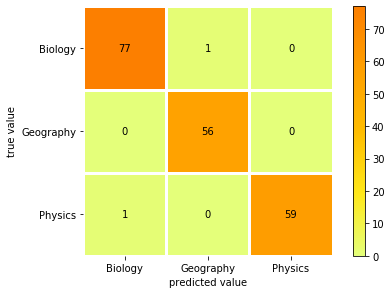

In [187]:
plot_confusion_matrix(confusion_matrix)
plt.show()